In [ ]:
import os
import csv
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST, SVHN
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve
!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa
import glob
import os.path as path
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-a07h3inm
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-a07h3inm


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Unknown_Detection/tiny-imagenet-200.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
class Closed_TINYIMAGENET():
    def __init__(self, size=(32,32), set_name='train',
                 path_to_data='/content/tiny-imagenet-200', 
                 isAugment=True):
        
        self.path_to_data = path_to_data        
        self.mapping_name2id = {}
        self.mapping_id2name = {}
        self.mapping_name2english_name = {}
        with open(path.join(self.path_to_data, 'wnids.txt')) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=' ')
            idx = 0
            for row in csv_reader:
                if idx >= 180: 
                  break
                self.mapping_id2name[idx] = row[0]
                self.mapping_name2id[row[0]] = idx
                idx += 1
        with open(path.join(self.path_to_data, 'words.txt')) as csv_file: 
          csv_reader = csv.reader(csv_file, delimiter=' ')
          idx = 0
          for row in csv_reader:
            row = row[0].split('\t')
            self.mapping_name2english_name[row[0]] = row[1]
            idx += 1


        assert len(self.mapping_id2name) == len(self.mapping_name2id) == 180
        
        
        if set_name=='test':  set_name = 'val'
        
        self.size = size
        self.set_name = set_name
        self.path_to_data = path_to_data
        self.isAugment = isAugment
        
        self.imageNameList  = []
        self.className = []
        self.labelList = []
        self.mappingLabel2Name = dict()
        curLabel = 0

        if self.set_name == 'val':
            with open(path.join(self.path_to_data, 'val', 'val_annotations.txt')) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter='\t')
                line_count = 0
                for row in csv_reader:
                    if row[1] not in self.mapping_name2id: continue
                    self.imageNameList += [path.join(self.path_to_data, 'val', 'images', row[0])]
                    self.labelList += [self.mapping_name2id[row[1]]]
        else: # 'train'
            self.current_class_dir = path.join(self.path_to_data, self.set_name)
            for curClass in os.listdir(self.current_class_dir):                 
                if curClass[0]=='.':   continue
                if curClass not in self.mapping_name2id: continue
                
                curLabel = self.mapping_name2id[curClass]
                for curImg in os.listdir(path.join(self.current_class_dir, curClass, 'images')):
                    if curImg[0]=='.':    continue
                    self.labelList += [curLabel]
                    self.imageNameList += [path.join(self.path_to_data, self.set_name, curClass, 'images', curImg)]

        
        self.current_set_len = len(self.labelList)
        
        if self.set_name=='test' or self.set_name=='val' or  not self.isAugment:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4), 
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])            # ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        else:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curLabel = np.asarray(self.labelList[idx])
        curImage = self.imageNameList[idx]
        curImage = PIL.Image.open(curImage).convert('RGB')
        curImage = self.transform(curImage)
        
        #print(idx, curLabel)
        
        #curLabel = torch.tensor([curLabel]).unsqueeze(0).unsqueeze(0)

        return curImage, torch.ones(curLabel.shape)

In [ ]:
class Aug_Closed_TINYIMAGENET():
    def __init__(self, transforms, size=(32,32), set_name='train',
                 path_to_data='/content/tiny-imagenet-200', 
                 isAugment=True):
        
        self.path_to_data = path_to_data        
        self.mapping_name2id = {}
        self.mapping_id2name = {}
        self.mapping_name2english_name = {}
        with open(path.join(self.path_to_data, 'wnids.txt')) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=' ')
            idx = 0
            for row in csv_reader:
                if idx >= 180: 
                  break
                self.mapping_id2name[idx] = row[0]
                self.mapping_name2id[row[0]] = idx
                idx += 1
        with open(path.join(self.path_to_data, 'words.txt')) as csv_file: 
          csv_reader = csv.reader(csv_file, delimiter=' ')
          idx = 0
          for row in csv_reader:
            row = row[0].split('\t')
            self.mapping_name2english_name[row[0]] = row[1]
            idx += 1


        assert len(self.mapping_id2name) == len(self.mapping_name2id) == 180
        
        
        if set_name=='test':  set_name = 'val'
        
        self.size = size
        self.set_name = set_name
        self.path_to_data = path_to_data
        self.isAugment = isAugment
        
        self.imageNameList  = []
        self.className = []
        self.labelList = []
        self.mappingLabel2Name = dict()
        curLabel = 0

        if self.set_name == 'val':
            with open(path.join(self.path_to_data, 'val', 'val_annotations.txt')) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter='\t')
                line_count = 0
                for row in csv_reader:
                    if row[1] not in self.mapping_name2id: continue
                    self.imageNameList += [path.join(self.path_to_data, 'val', 'images', row[0])]
                    self.labelList += [self.mapping_name2id[row[1]]]

        self.transforms = transforms 
        self.current_set_len = len(self.labelList)    
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curLabel = np.asarray(self.labelList[idx])
        curImage = self.imageNameList[idx]
        curImage = cv2.imread(curImage)
        curImage = cv2.cvtColor(curImage, cv2.COLOR_RGB2BGR)
        curImage = self.transforms(image = curImage)

        trans = transforms.Compose([
                transforms.ToPILImage(), 
                transforms.RandomCrop(self.size[0], padding=4),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])
        curImage = trans(curImage)
      
        
        #print(idx, curLabel)
        
        #curLabel = torch.tensor([curLabel]).unsqueeze(0).unsqueeze(0)

        return curImage, torch.zeros(curLabel.shape)

Length of testTinyImageNet is 9000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


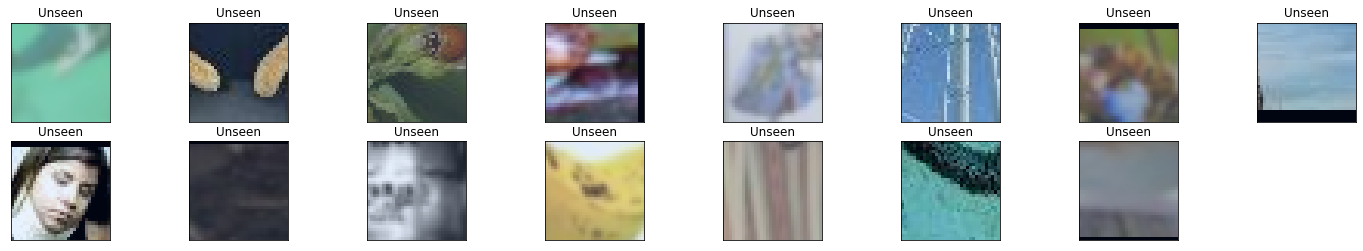

In [ ]:
# transforms_noisyOE = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.pillike.EnhanceContrast(), 
#     iaa.GaussianBlur(sigma=(0.1, 2)), 
#     iaa.Rain(speed=(0.5, 0.9))
# ])

transforms_noisyOE = iaa.Sequential([
    iaa.pillike.EnhanceContrast(), 
    iaa.GaussianBlur(sigma=(0.1, 1))
])

batch_size = 32
classes = ["Unseen", "Seen"]

augmented_testTinyImageNet = Aug_Closed_TINYIMAGENET(set_name = 'val', transforms = transforms_noisyOE)
augmented_testTinyImageNetLoader = torch.utils.data.DataLoader(augmented_testTinyImageNet, batch_size = 32, shuffle = True)
print("Length of testTinyImageNet is {}".format(len(augmented_testTinyImageNet)))

# Plot train images
test_dataiter = iter(augmented_testTinyImageNetLoader)
images, targets = next(test_dataiter)
assert max(targets) < 180
images = images.numpy()
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[int(targets[idx].item())])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

Length of testTinyImageNet is 9000
(32, 3, 32, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


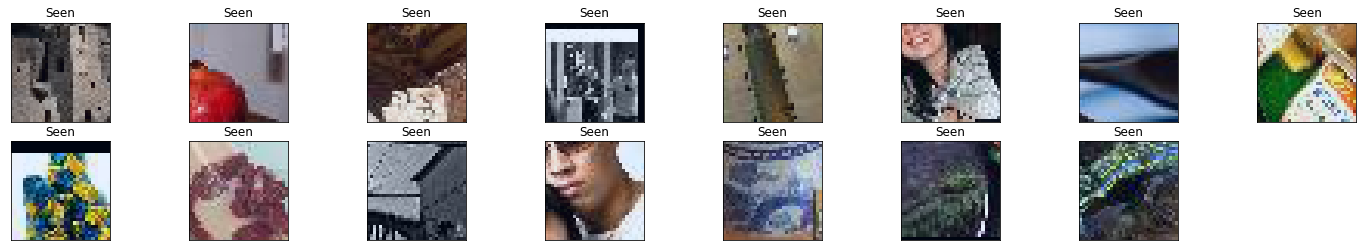

In [ ]:
batch_size = 32
classes = ["Unseen", "Seen"]

testTinyImageNet = Closed_TINYIMAGENET(set_name = 'test')
testTinyImageNetLoader = torch.utils.data.DataLoader(testTinyImageNet, batch_size = 32, shuffle = True)
print("Length of testTinyImageNet is {}".format(len(testTinyImageNet)))

# Plot train images
test_dataiter = iter(testTinyImageNetLoader)
images, targets = next(test_dataiter)
assert max(targets) < 180
images = images.numpy()
images -= images.min() 
images /= images.max()
print(images.shape)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[int(targets[idx].item())])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

In [ ]:
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

class SplitCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, mode, transformFunc, iaa_compat = False, rain = False):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()
        self.iaa_compat = iaa_compat
        self.rain = rain

        if mode == "train": 
          for v in img2targets:
            _, target = v
            if target < split: 
              self.data.append(v)
        elif mode == "test": 
          for v in img2targets: 
            _, target = v 
            if target >= split: 
              self.data.append(v)
        else: 
          raise ValueError("Not a mode")
        
        self.transformFunc = transformFunc

        if self.iaa_compat: 
          self.contents = ["UNSEEN"] * (len(self.data) // 2)
          left = len(self.data) - len(self.contents)
          self.contents.extend((["SEEN"] * left))

          assert len(self.contents) == len(self.data)

          self.normal_transform = transforms.Compose([
                                                      transforms.ToPILImage(), 
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize(mean, std)])                             
    def __getitem__(self, i):
       img, target = self.data[i]
       if self.iaa_compat: 
         if self.contents[i] == "UNSEEN":
           img = self.transformFunc(image = img)
           target = torch.tensor(0, dtype = int)
         else: 
           '''SEEN data'''
           if self.rain: 
             img = self.transformFunc(image = img)
           target = torch.tensor(1, dtype = int)

         img = self.normal_transform(img)
         return img, target 
       else: 
         img = self.transformFunc(img)
         return img, target

    def __len__(self):
        return len(self.data)

batch_size = 32

split = 60
testset = CIFAR10(root='./data', train=False, download=True)
test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])
test_closedset_CIFAR = SplitCIFAR(testset.data, testset.targets, split, "train", test_transform)
len(test_closedset_CIFAR)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


10000

In [ ]:
eurosat_data = torchvision.datasets.EuroSAT("/content", download = True)
# places_365 = torchvision.datasets.SUN397("/content", download = True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


In [ ]:
eurosat_data

Dataset EuroSAT
    Number of datapoints: 27000
    Root location: /content

In [ ]:
class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, root):
      self.images = glob.glob(os.path.join(root, "2750", "*", "*.jpg"))   
      self.transform = transforms.Compose([transforms.ToPILImage(), 
                                           transforms.Resize(32), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])                          
    def __getitem__(self, i):
       image = cv2.cvtColor(cv2.imread(self.images[i]), cv2.COLOR_RGB2BGR)
       image = self.transform(image)

       return image, torch.tensor(0)

    def __len__(self):
      return len(self.images)
euro_dataset = EuroSAT_Dataset("/content/eurosat")
euro_dl = torch.utils.data.DataLoader(euro_dataset, batch_size = 32, shuffle = True)

In [ ]:
# Metrics: 

def F_measure(preds, labels, openset=False, theta=None):
  if openset:
      # f1 score for openset evaluation
      true_pos = 0.
      false_pos = 0.
      false_neg = 0.        
      for i in range(len(labels)):
          true_pos += 1 if preds[i] == labels[i] and labels[i] != -1 else 0
          false_pos += 1 if preds[i] != labels[i] and labels[i] != -1 else 0
          false_neg += 1 if preds[i] != labels[i] and labels[i] == -1 else 0

      precision = true_pos / (true_pos + false_pos)
      recall = true_pos / (true_pos + false_neg)
      return 2 * ((precision * recall) / (precision + recall + 1e-12))
  else: # Regular f1 score        
      return f1_score(labels, preds, average='macro')

def roc(scores, labels, **kwargs):
    """Returns the ROC curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)
    roc_data = {
        'tp': list(tpr),
        'fp': list(fpr),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return roc_data


def pr(scores, labels, **kwargs):
    """Returns the PR curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    auc_score = auc(recall, precision)

    pr_data = {
        'precision': list(precision),
        'recall': list(recall),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return pr_data

def ccr(scores, labels, **kwargs):
    """Returns the CCR VS FPR curve and returns the area under it.

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    max_indices = np.argmax(scores, axis=1) # Nx(K+1)
    max_values = np.take_along_axis(scores, max_indices[:, None], axis=1)
    data = list(zip([elem[0] for elem in max_values], max_indices, labels))
    data.sort(key=lambda x: x[0], reverse=True)
    cls_count = len(scores[0])
    unknown_count = len(np.where(labels == 0)[0])  # Unknown class is 0
    known_count = len(labels) - unknown_count
    fp = [0]
    tp = [0]
    thresholds = list()
    n = 0
    n_above_unknown = 0
    curr_unknown_prob = 1
    for score, pred_cls, gt_cls in data:
        if gt_cls == 0:
            curr_unknown_prob = score
            thresholds.append(score)
            fp.append(fp[-1] + 1)
            tp.append(n)
        elif pred_cls == gt_cls:
            n_above_unknown += 1
            if score < curr_unknown_prob:
                n = n_above_unknown
    fpr = np.asarray(fp[1:]) / unknown_count
    ccr = np.asarray(tp[1:]) / known_count
    auc_score = auc(fpr, ccr)
    ccr_data = {
        'ccr': list(ccr),
        'fpr': list(fpr),
        'thresh': thresholds,
        'auc': auc_score,
    }
    return ccr_data
    

# Initialize The Model

In [ ]:
!git clone https://github.com/aimerykong/OpenGAN.git
%cd "/content/OpenGAN"

Cloning into 'OpenGAN'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 66 (delta 28), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (66/66), done.
/content/OpenGAN


In [ ]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle

import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path

from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
# import PIL.Image
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from tqdm import tqdm 
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10, MNIST, SVHN
from collections import namedtuple

# from config_HRNet import models
# from config_HRNet import seg_hrnet
# from config_HRNet import config
# from config_HRNet import update_config
# from config_HRNet.modelsummary  import *
# from config_HRNet.utils import *


from utils.dataset_tinyimagenet import *
from utils.dataset_cityscapes import *
from utils.eval_funcs import *

!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-ei4nvrcg
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-ei4nvrcg
3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
1.12.1+cu113


In [ ]:
# set the random seed
torch.manual_seed(0)


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

num_open_training_images = 1000
weight_adversarialLoss = 0.2
project_name = 'demo_step030_OpenGAN_num{}_w{:.2f}'.format(num_open_training_images, weight_adversarialLoss)


device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'
        


ganBatchSize = 64 # 32 fake images
batch_size = 64
newsize = (-1,-1)

total_epoch_num = 20 # total number of epoch in training
insertConv = False    
embDimension = 64
#isPretrained = False
#encoder_num_layers = 18


# Number of channels in the training images. For color images this is 3
nc = 2048
# Size of z latent vector (i.e. size of generator input)
nz = 64
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


save_dir = os.path.join(exp_dir, project_name)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)

lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     

class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=2048, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers=18, isPretrained=False, isGrayscale=False, embDimension=128, poolSize=4):
        super(ResnetEncoder, self).__init__()
        self.path_to_model = '../models'
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        self.isGrayscale = isGrayscale
        self.isPretrained = isPretrained
        self.embDimension = embDimension
        self.poolSize = poolSize
        self.featListName = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4']
        
        resnets = {
            18: models.resnet18, 
            34: models.resnet34,
            50: models.resnet50, 
            101: models.resnet101,
            152: models.resnet152}
        
        resnets_pretrained_path = {
            18: 'resnet18-5c106cde.pth', 
            34: 'resnet34.pth',
            50: 'resnet50.pth',
            101: 'resnet101.pth',
            152: 'resnet152.pth'}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(
                num_layers))

        self.encoder = resnets[num_layers]()
        
        if self.embDimension>0:
            self.encoder.linear =  nn.Linear(self.num_ch_enc[-1], self.embDimension)
        
        if self.isPretrained:
            print("using pretrained model")
            self.encoder.load_state_dict(
                torch.load(os.path.join(self.path_to_model, resnets_pretrained_path[num_layers])))
        
        #if self.isGrayscale:
        #    self.encoder.conv1 = nn.Conv2d(
        #        1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #else:
        #    self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        
        x = self.encoder.conv1(input_image)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        self.features.append(x)
        
        #x = self.encoder.layer1(self.encoder.maxpool(x)) # 
        x = self.encoder.layer1(x) # self.encoder.maxpool(x)
        self.features.append(x)
        #print('layer1: ', x.shape)
        
        x = self.encoder.layer2(x)
        self.features.append(x)
        #print('layer2: ', x.shape)
        
        x = self.encoder.layer3(x) 
        self.features.append(x)
        #print('layer3: ', x.shape)       
        
        x = self.encoder.layer4(x)
        self.features.append(x)
        #print('layer4: ', x.shape)
        
        x = F.avg_pool2d(x, self.poolSize)
        #print('global pool: ', x.shape)
        
        x = x.view(x.size(0), -1)
        #print('reshape: ', x.shape)
        
        if self.embDimension>0:
            x = self.encoder.linear(x)
        #print('final: ', x.shape)
        return x

def build_max_model(kway_model_path): 

  resnet50 = ResnetEncoder(num_layers = 50, embDimension = -1, poolSize=2)
  del resnet50.encoder.fc

  state_dict = torch.load(kway_model_path)
  new_keys = dict()
  for k in list(state_dict.keys()): 
    new_keys[k] = "encoder." + k
  
  modified_state_dict = dict((new_keys[key], value) for (key, value) in state_dict.items())

  del modified_state_dict['encoder.fc.weight']
  del modified_state_dict['encoder.fc.bias']

  resnet50.load_state_dict(modified_state_dict)
  resnet50.eval()

  return resnet50

resnet50 = build_max_model("/content/drive/MyDrive/Unknown_Detection/50KWayModelAugust21.pth")

def load_discriminator(model_path): 
  discriminator = Discriminator()
  state_dict = torch.load(model_path)
  discriminator.load_state_dict(state_dict)
  discriminator.eval()
  discriminator.to(device) 

  return discriminator 

./exp/demo_step030_OpenGAN_num1000_w0.20


In [ ]:
def evaluate_bn_roc_pr(dis_model_path, kway_model_path, openDataset, closedDataset):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 32, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 32, shuffle = True)

  if len(openDataset) > len(closedDataset): 
    for_loop_loader = "closedDataLoader"
    iter_loader = "openDataLoader"
  else: 
    for_loop_loader = "openDataLoader"
    iter_loader = "closedDataLoader"
  
  print("For Loop Loader is {}".format(for_loop_loader))
  print("Iter Loop Loader is {}".format(iter_loader))

  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(eval(iter_loader))
  for for_data, for_targets in tqdm(eval(for_loop_loader)): 
      iter_data, iter_targets = next(dateiter)
      if for_loop_loader=="closedDataLoader": 
        for_targets = torch.ones(*for_targets.size())
        iter_targets = torch.zeros(*iter_targets.size())
      else: 
        for_targets = torch.zeros(*for_targets.size())
        iter_targets = torch.ones(*iter_targets.size())
      iter_data, iter_targets = iter_data.cuda(), iter_targets.cuda()
      for_data, for_targets = for_data.cuda(), for_targets.cuda()
      
      # print(for_targets)
      # for_data -= for_data.mean()
      # for_data /= for_data.std()
      # iter_data -= iter_data.mean()
      # iter_data /= iter_data.std()
      # plt.imshow(for_data[0].permute(1, 2, 0).cpu().numpy())
      # assert 1 == 2

      data = torch.cat((iter_data, for_data), 0)
      target = torch.cat((iter_targets, for_targets), 0)

      disc.eval()

      #forward
      x_feat = kway(data.float())[:, :, None, None]
      out = disc(x_feat)
      out = out.view(-1)

      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

Len of Entire Dataset 73257


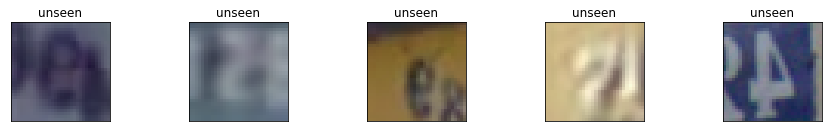

In [ ]:
# Load Outlier Exposure datasets
# Train Datasets
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

mnist_OEtrainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
svhn_OEtrainset = torchvision.datasets.SVHN(root = './data', split = "train", download = True)

# Test Datasets
mnist_OEtestset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
svhn_OEtestset = torchvision.datasets.SVHN(root = './data', split = "test", download = True)

# testset = CIFAR10(root='./data', train=False, download=True)
# trainset = CIFAR10(root='./data', train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.RandomHorizontalFlip(), 
    transforms.Resize(32),                  
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))
])


test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])

class OpenSetSVHN(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, New_dataset_images, New_dataset_targets, transformFunc, OpenSetRec = False, MNIST = False):

    self.data = list()
    img2targets = list(zip(New_dataset_images, New_dataset_targets))

    for v in img2targets: 
      if not OpenSetRec: 
        self.data.append((v[0], 0)) # 0 is unseen
      else: 
        self.data.append((v[0], torch.tensor([0, 0])))
      
    
    self.transformFunc = transformFunc
    self.MNIST = MNIST
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    if type(img) != np.ndarray and self.MNIST: 
      # MNIST
      img = img.to(float)

      channel_1 = img.unsqueeze(0)
      channel_2 = channel_1.clone()
      channel_3 = channel_1.clone()
      
      img = torch.cat((channel_1, channel_2, channel_3), dim = 0)
      
      img = transforms.Resize(32)(img) 
      
    img = self.transformFunc(img)
    return img, target

  def __len__(self):
    return len(self.data)


train_OpenSetSVHN = OpenSetSVHN(torch.from_numpy(svhn_OEtrainset.data), torch.from_numpy(svhn_OEtrainset.labels), train_transform)
train_OpenSetSVHNLoader = torch.utils.data.DataLoader(train_OpenSetSVHN, batch_size = 16, shuffle = True)

mixed_classes = ["unseen", "seen"]
train_newDatasetAndCIFARiter = iter(train_OpenSetSVHNLoader)
imgs, targets = next(train_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [ ]:
test_OpenSetMNIST = OpenSetSVHN(mnist_OEtestset.data, mnist_OEtestset.targets, test_transform, MNIST = True)
test_OpenSetSVHN = OpenSetSVHN(torch.from_numpy(svhn_OEtestset.data), torch.from_numpy(svhn_OEtestset.labels), test_transform)

Len of Entire Dataset 10000
Len of Entire Dataset 26032


In [ ]:
img, _ = testTinyImageNet[0]
img.size()

torch.Size([3, 32, 32])

# Old tests

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Sep10thOpenGANon27thAugPretrainedKwayEpoch20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   euro_dataset, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:19<00:00, 14.44it/s]



ROC AU value: 94.85277593085107%
PR AU value: 94.86016807862586%


(94.85277593085107, 94.86016807862586)

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/Sep10thOpenGANon27thAugPretrainedKwayEpoch20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   test_OpenSetSVHN, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:21<00:00, 12.86it/s]



ROC AU value: 99.58021572104019%
PR AU value: 99.5269474649005%


(99.58021572104019, 99.5269474649005)

In [ ]:
def evaluate_bn_roc_pr_aug(dis_model_path, kway_model_path, openDataset, closedDataset):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  aug_openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 32, shuffle = True)
  norm_closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 32, shuffle = True)

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(aug_openDataLoader)
  for norm_data, norm_targets in tqdm(norm_closedDataLoader): 
      aug_data, aug_targets = next(dateiter)
      aug_data, aug_targets = aug_data.cuda(), aug_targets.cuda()
      norm_data, norm_targets = norm_data.cuda(), norm_targets.cuda()
      
      data = torch.cat((norm_data, aug_data), 0)
      target = torch.cat((norm_targets, aug_targets), 0)

      disc.eval()

      #forward
      x_feat = kway(data.float())[:, :, None, None]
      out = disc(x_feat)
      out = out.view(-1)

      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
print("Augmented Dataset {}".format(len(augmented_testTinyImageNet)))
print("testTinyImageNet {}".format(len(testTinyImageNet)))
evaluate_bn_roc_pr_aug("/content/drive/MyDrive/Unknown_Detection/Sep10thOpenGANon27thAugPretrainedKwayEpoch20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   augmented_testTinyImageNet, testTinyImageNet)

Augmented Dataset 9000
testTinyImageNet 9000


100%|██████████| 282/282 [01:30<00:00,  3.10it/s]



ROC AU value: 87.37495925925924%
PR AU value: 83.19870638856305%


(87.37495925925924, 83.19870638856305)

# Use Max Logits Instead Now

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, split)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

def evaluate_max_models(form, kway_model_path, data_loader): 

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  for data, target in tqdm(data_loader): 

    data, target = data.cuda(), target.cuda()
    num_of_data += data.size(0)

    #forward
    x = net(data.float())

    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())

  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, 180)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

# def build_max_model(kway_model_path): 

#   resnet50 = torchvision.models.resnet50(pretrained=True)
#   resnet50.fc = nn.Linear(resnet50.fc.in_features, 180)

  
#   resnet50.eval()

#   return resnet50

def evaluate_max_logits_aug(kway_model_path, openDataset, closedDataset, form = 'logits'): 

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 16, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 16, shuffle = True)

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  dateiter = iter(openDataLoader)
  for closed_data, closed_targets in tqdm(closedDataLoader): 
    closed_targets = torch.ones(closed_targets.size())
    open_data, open_targets = next(dateiter)
    open_targets = torch.zeros(open_targets.size())
    closed_data, closed_targets = closed_data.cuda(), closed_targets.cuda()

    open_data, open_targets = open_data.cuda(), open_targets.cuda()
    closed_data, closed_targets = closed_data.cuda(), closed_targets.cuda()
    data = torch.cat((open_data, closed_data), 0)
    target = torch.cat((open_targets, closed_targets), 0)

    num_of_data += data.size(0)

    #forward
    x = net(data.float())

    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())
  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
evaluate_max_logits_aug("/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", augmented_testTinyImageNet, testTinyImageNet, form = 'logits')

100%|██████████| 563/563 [00:30<00:00, 18.56it/s]




ROC AU value: 57.73357962962964%
PR AU value: 57.72494883221142%


(57.73357962962964, 57.72494883221142)

In [ ]:
evaluate_max_logits_aug("/content/drive/MyDrive/Unknown_Detection/50KWayModelAugust21.pth", test_OpenSetMNIST, testTinyImageNet, form = 'logits')


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

100%|██████████| 563/563 [00:16<00:00, 34.68it/s]




ROC AU value: 81.57578263765541%
PR AU value: 85.85904685216002%


(81.57578263765541, 85.85904685216002)

In [ ]:
evaluate_max_logits_aug("/content/model_epoch25 (2).pth", test_closedset_CIFAR, testTinyImageNet, form = 'logits')

100%|██████████| 563/563 [00:13<00:00, 40.85it/s]




ROC AU value: 50.09053557331755%
PR AU value: 55.71648042438051%


(50.09053557331755, 55.71648042438051)

In [ ]:
evaluate_max_logits_aug("/content/model_epoch25 (2).pth", test_OpenSetMNIST, testTinyImageNet, form = 'logits')

In [ ]:
evaluate_max_logits_aug("/content/model_epoch25 (2).pth", test_OpenSetSVHN, testTinyImageNet, form = 'logits')

100%|██████████| 563/563 [00:14<00:00, 39.83it/s]



ROC AU value: 49.879751948884945%
PR AU value: 58.05278336919875%


(49.879751948884945, 58.05278336919875)

# Valid Logits on Noise

In [ ]:
def validate_logits_on_noise(kway_model_path, datasets, noise_type, form): 

  kway = build_max_model(kway_model_path)

  DataLoader = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle = True)

  '''Only will find ROC and PR Metrics'''

  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(DataLoader)
  for i in tqdm(range(563)):
    if (i % 2) == 0: 
      images, targets = next(dateiter)
      images = images[0]
      images = images.unsqueeze(0)
      targets = torch.ones(1)
    else: 
      if noise_type == "normal": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.normal(mu, sigma, size = (1, 3, 32, 32)))
      elif noise_type == "uniform": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.uniform(mu, sigma, size = (1, 3, 32, 32)))
      targets = torch.zeros(1)

    images = images.cuda()
    targets = targets.cuda()

    #forward
    x = kway(images.float())
    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_outs.extend(max.tolist()) 
    stacked_targets.extend(targets.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
validate_logits_on_noise("/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", testTinyImageNet, "uniform", "logits")

100%|██████████| 563/563 [00:11<00:00, 47.52it/s]



ROC AU value: 26.897352414123826%
PR AU value: 46.19532016745767%


(26.897352414123826, 46.19532016745767)

# Evaluate Logits Seperately for The BatchNorm test

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, 180)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

def evaluate_max_logits_aug_ind(kway_model_path, openDataset, closedDataset, form = 'logits'): 

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 16, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 16, shuffle = True)

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  dateiter = iter(openDataLoader)
  for closed_data, closed_targets in tqdm(closedDataLoader): 
    closed_targets = torch.ones(closed_targets.size())
    open_data, open_targets = next(dateiter)
    open_targets = torch.zeros(open_targets.size())
    closed_data, closed_targets = closed_data.cuda(), closed_targets.cuda()

    open_data, open_targets = open_data.cuda(), open_targets.cuda()
    closed_data, closed_targets = closed_data.cuda(), closed_targets.cuda()

    target = torch.cat((open_targets, closed_targets), 0)
    
    

    #forward
    open_x = net(open_data.float())
    closed_x = net(closed_data.float())

    # if form == "softmax":
    #   # Softmax Probability
    #   x = F.softmax(x, dim=1)
    #   assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    open_max = torch.max(open_x, dim = 1).values
    closed_max = torch.max(closed_x, dim = 1).values
    max = torch.cat((open_max, closed_max), 0)
    num_of_data += max.size(0)

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())
  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
def evaluate_bn_roc_pr_ind(dis_model_path, kway_model_path, openDataset, closedDataset):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 32, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 32, shuffle = True)

  if len(openDataset) > len(closedDataset): 
    for_loop_loader = "closedDataLoader"
    iter_loader = "openDataLoader"
  else: 
    for_loop_loader = "openDataLoader"
    iter_loader = "closedDataLoader"
  
  print("For Loop Loader is {}".format(for_loop_loader))
  print("Iter Loop Loader is {}".format(iter_loader))

  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(eval(iter_loader))
  for for_data, for_targets in tqdm(eval(for_loop_loader)): 
      iter_data, iter_targets = next(dateiter)
      if for_loop_loader=="closedDataLoader": 
        for_targets = torch.ones(*for_targets.size())
        iter_targets = torch.zeros(*iter_targets.size())
      else: 
        for_targets = torch.zeros(*for_targets.size())
        iter_targets = torch.ones(*iter_targets.size())
      iter_data, iter_targets = iter_data.cuda(), iter_targets.cuda()
      for_data, for_targets = for_data.cuda(), for_targets.cuda()
      
      # data = torch.cat((iter_data, for_data), 0)
      target = torch.cat((iter_targets, for_targets), 0)

      disc.eval()

      #forward
      iter_x_feat = kway(iter_data.float())[:, :, None, None]
      for_x_feat = kway(for_data.float())[:, :, None, None]

      iter_out = disc(iter_x_feat)
      iter_out = iter_out.view(-1)

      for_out = disc(for_x_feat)
      for_out = for_out.view(-1)

      out = torch.cat((iter_out, for_out), 0)
      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
evaluate_max_logits_aug_ind("/content/drive/MyDrive/Unknown_Detection/Sep10thOpenGANon27thAugPretrainedKwayEpoch20.classifier", test_OpenSetSVHN, testTinyImageNet, form = 'logits')

In [ ]:
evaluate_max_logits_aug_ind("/content/model_epoch25 (2).pth", test_OpenSetSVHN, testTinyImageNet, form = 'logits')

100%|██████████| 563/563 [00:19<00:00, 28.93it/s]



ROC AU value: 49.12244116341029%
PR AU value: 57.99171813878996%


(49.12244116341029, 57.99171813878996)

In [ ]:
evaluate_max_logits_aug_ind("/content/model_epoch25 (2).pth", test_closedset_CIFAR, testTinyImageNet, form = 'logits')

100%|██████████| 563/563 [00:17<00:00, 31.94it/s]




ROC AU value: 50.20761668640221%
PR AU value: 55.887375907471096%


(50.20761668640221, 55.887375907471096)

# Evaluate OpenGAN without BatchNorm

In [ ]:
evaluate_bn_roc_pr_ind("/content/drive/MyDrive/Unknown_Detection/OPenGANTestTinyImageNetNotPretrainedSep5th.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   euro_dataset, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:17<00:00, 16.40it/s]



ROC AU value: 93.09754851260837%
PR AU value: 93.06123483536456%


(93.09754851260837, 93.06123483536456)

In [ ]:
evaluate_bn_roc_pr_ind("/content/epoch-16.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   test_OpenSetMNIST, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:24<00:00, 11.72it/s]



ROC AU value: 76.7195977393617%
PR AU value: 80.00753742920666%


(76.7195977393617, 80.00753742920666)

In [ ]:
evaluate_bn_roc_pr_ind("/content/epoch-16.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   test_closedset_CIFAR, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:15<00:00, 18.67it/s]



ROC AU value: 86.00419313928289%
PR AU value: 87.14188303680386%


(86.00419313928289, 87.14188303680386)